In [ ]:
import sys
sys.path.append("./poligenx_folder")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os.path as osp
from glob import glob
from tqdm.notebook import tqdm
import re
from pathlib import Path
import pandas as pd

In [4]:
from typing import Any
from argparse import Namespace
import typing

class DotDict(Namespace):
    """A simple class that builds upon `argparse.Namespace`
    in order to make chained attributes possible."""

    def __init__(self, temp=False, key=None, parent=None) -> None:
        self._temp = temp
        self._key = key
        self._parent = parent

    def __eq__(self, other):
        if not isinstance(other, DotDict):
            return NotImplemented
        return vars(self) == vars(other)

    def __getattr__(self, __name: str) -> Any:
        if __name not in self.__dict__ and not self._temp:
            self.__dict__[__name] = DotDict(temp=True, key=__name, parent=self)
        else:
            del self._parent.__dict__[self._key]
            raise AttributeError("No attribute '%s'" % __name)
        return self.__dict__[__name]

    def __repr__(self) -> str:
        item_keys = [k for k in self.__dict__ if not k.startswith("_")]

        if len(item_keys) == 0:
            return "DotDict()"
        elif len(item_keys) == 1:
            key = item_keys[0]
            val = self.__dict__[key]
            return "DotDict(%s=%s)" % (key, repr(val))
        else:
            return "DotDict(%s)" % ", ".join(
                "%s=%s" % (key, repr(val)) for key, val in self.__dict__.items()
            )

    @classmethod
    def from_dict(cls, original: typing.Mapping[str, any]) -> "DotDict":
        """Create a DotDict from a (possibly nested) dict `original`.
        Warning: this method should not be used on very deeply nested inputs,
        since it's recursively traversing the nested dictionary values.
        """
        dd = DotDict()
        for key, value in original.items():
            if isinstance(value, typing.Mapping):
                value = cls.from_dict(value)
            setattr(dd, key, value)
        return dd

from collections import defaultdict

class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def create_list_defaultdict():
    return defaultdict(list)


defaults_d = {

     'minimize_property': False,
     'mp_index': 0,
     'use_lipinski_context': False,
     'context_fixed': None,
     'model_path': None,
     'skip_existing': False,
     'dataset_root': None, 
     'save_xyz': False, 
     'calculate_energy': False, 
     'num_ligands_per_pocket_to_sample': 100,
     'num_ligands_per_pocket_to_save': 100, 
     'build_obabel_mol': False, 
     'dist_cutoff': 5.0, 'ddim': False, 'eta_ddim': 1.0, 
     'relax_mol': False, 'sanitize': False, 'max_relax_iter': 200,
     'test_dir_10A': None, 
     'test_list': None, 
     'save_dir': None,
     'filter_by_posebusters': False, 
     'filter_by_lipinski': False,
     'filter_by_sascore': False,
     'sascore_threshold': 0.7, 
     'filter_by_docking_scores': False, 
     'docking_scores': None, 
     'omit_posebusters': False, 'omit_posecheck': False, 
     'ckpt_property_model': None, 'ckpt_sa_model': None, 'ckpts_ensemble': [], 
     'property_classifier_guidance': False, 'property_classifier_self_guidance': False, 
     'property_classifier_guidance_complex': False, 'classifier_guidance_scale': 0.0001,
     'joint_importance_sampling': False, 
     'max_sample_iter': 20, 
     'inpainting': False,
     'clash_guidance_start': 0,
     'use_lipinski_context': False,
     'context_fixe': False,
     'clash_guidance': False,
     'clash_guidance_start': None,
     'clash_guidance_end': None,
     'emd_ot': False,
     'importance_gradient_guidance': True,
     'property_importance_sampling': False,
     'property_importance_sampling_start': None,
     'property_importance_sampling_end': None,
     'property_every_importance_t': None,
     'property_tau=property_tau': None,
     'property_normalization': False,
     'maximize_property': True,
 }

In [5]:
from pytorch_lightning import seed_everything
seed_everything(123)

[rank: 0] Global seed set to 123


123

In [6]:
import rdkit
from rdkit import Chem
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Batch, Data

In [7]:
from experiments.data.data_info import GeneralInfos as DataInfos
from experiments.utils import get_lipinski_properties, calculate_sa
from experiments.data.ligand.ligand_dataset_nonadaptive import (
    LigandPocketDataModule as DataModule,
)
from experiments.data.utils import mol_to_torch_geometric
from experiments.sampling.utils import get_fingerprints
from rdkit.DataStructs import BulkTanimotoSimilarity, TanimotoSimilarity


# pocket preparation and ligand generation functions
from experiments.utils import (
    prepare_data,
    prepare_data_and_generate_ligands
)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [8]:
from Bio.PDB import PDBParser

In [9]:
# regex for extracting docking score in string
rg = r'[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?'
extract_score = lambda x: float(re.findall(rg, x.GetProp("REMARK").split("\n")[0].strip())[0])

def get_top_k(arr, k=0.1):
    arr = np.sort(arr)
    ids = int(k * len(arr))
    return arr[:ids]

In [10]:
class TmpCfg():
    def __init__(self, dataset_root, dataset, regression_property, batch_size=16) -> None:
        self.remove_hs = True
        self.dataset_root = dataset_root
        self.batch_size = batch_size
        self.num_workers = 1
        self.dataset = dataset
        self.joint_property_prediction = True
        self.regression_property = regression_property
        self.property_training = False
        self.num_bond_classes = 5
        self.num_charge_classes = 6

In [11]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device("cpu")

## CrossDocked
Here we show inference code how to generate ligands on the CrossDocked dataset.  


In [ ]:
ckpt = Path("./poligenx_folder/crossdocked/modeldir/")

In [ ]:
dataset_root="./poligenx_folder/crossdocked/dataset"

In [14]:
cfg = TmpCfg(dataset_root=dataset_root,
             dataset="crossdocked",
             regression_property=["sa_score"],
             batch_size=16)
datamodule = DataModule(cfg)
dataloader = datamodule.val_dataloader()
pocket_data = next(iter(dataloader)).to(device)
pocket_data

/sharedhome/let55/miniforge3/envs/e3mol/lib/python3.10/site-packages/torch_geometric/data/lightning/datamodule.py:49: UserWarning: The 'shuffle=True' option is ignored in 'LigandPocketDataModule'. Remove it from the argument list to disable this warning
  warnings.warn(f"The 'shuffle={kwargs['shuffle']}' option is "
/sharedhome/let55/miniforge3/envs/e3mol/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


DataBatch(x=[307], edge_index=[2, 656], edge_attr=[656], pos=[307, 3], pos_batch=[307], pos_ptr=[17], charges=[307], smiles=[16], is_aromatic=[307], is_in_ring=[307], is_h_donor=[307], is_h_acceptor=[307], hybridization=[307], mol=[16], pos_lig=[307, 3], x_lig=[307], pos_pocket=[2233, 3], pos_pocket_batch=[2233], pos_pocket_ptr=[17], x_pocket=[2233], lig_mask=[307], pocket_mask=[2233], pocket_ca_mask=[2233], pocket_one_hot=[270, 20], pocket_one_hot_batch=[270], pocket_one_hot_ptr=[17], pocket_one_hot_mask=[270], batch=[307], ptr=[17])

In [15]:
dataset_info = DataInfos(datamodule=datamodule, cfg=cfg)
smiles_list = None

histogram = os.path.join(
                        cfg.dataset_root, "size_distribution.npy"
                    )
histogram = np.load(histogram).tolist()

In [16]:
list(map(len, (datamodule.train_dataset, datamodule.val_dataset, datamodule.test_dataset)))

[99923, 300, 100]

#### Load the trainer model class

In [17]:
from experiments.diffusion_discrete_pocket import Trainer
model = Trainer.load_from_checkpoint(ckpt / "best_valid.ckpt",
                                     histogram=histogram,
                                     dataset_info=dataset_info,
                                     smiles_list=datamodule.train_dataset.smiles,
                                     run_evaluation=True,
                                     strict=True,
).to(device)

Model without modeling explicit hydrogens
Entropy of n_nodes: H[N] 8.390420913696289


In [18]:
ff = torch.load(ckpt / "best_valid.ckpt", map_location=device)
model.load_state_dict(ff["state_dict"])
if isinstance(model.hparams.regression_property, str):
    model.hparams.regression_property = model.hparams.regression_property.split(",")

In [ ]:
test_dir = Path('./poligenx_folder/crossdocked/dataset/test')
test_files = sorted(list(test_dir.glob("[!.]*.sdf")))

In [20]:
sdf_file = test_files[0]

In [21]:
ligand_name = sdf_file.stem
pdb_name, pocket_id, *suffix = ligand_name.split("_")
pdb_file = Path(sdf_file.parent, f"{pdb_name}.pdb")
txt_file = Path(sdf_file.parent, f"{ligand_name}.txt")
residues_10A = None

with open(txt_file, "r") as f:
    resi_list = f.read().split()

assert (
    resi_list is not None
), "Pre-process pdb files extracting residues in specified cutoff and save as txt!"

pdb_struct = PDBParser(QUIET=True).get_structure("", pdb_file)[0]

residues = [
    pdb_struct[x.split(":")[0]][(" ", int(x.split(":")[1]), " ")]
    for x in resi_list
]
embedding_dict=None

#### Seed ligand for target

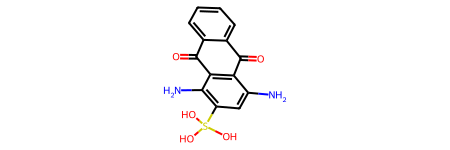

In [22]:
suppl = Chem.SDMolSupplier(str(sdf_file))
mol = []
for m in suppl:
    mol.append(m)
assert len(mol) == 1
reference_mol = mol[0]
reference_mol

In [23]:
reference_mol.GetNumAtoms()

22

### Configurations to choose

Perform sampling using the latent embedding from the seed ligand.
Let's choose to include the full influence of the latent setting the $\lambda=1.0$.  

Notice in the arguments, we call it `latent_gamma`.

In [24]:
batch_size = 32

In [25]:
d = {

     'latent_gamma': 1.,
     'encode_ligands': True,
    
     'num_gpus': 1, 
     'fix_n_nodes': True,
     'vary_n_nodes': False,
     'n_nodes_bias': 0,
     'prior_n_atoms': 'targetdiff',

     'sa_importance_sampling': False, 'sa_tau': 0.1, 'sa_every_importance_t': 5,
     'sa_importance_sampling_start': 0, 'sa_importance_sampling_end': 200,

    
     'test_dir': dataset_root + "/test/", 
     'pdbqt_dir': dataset_root + "/test/pdbqt/",
    
     'batch_size': batch_size,
}

d.update(defaults_d)
args = DotDict.from_dict(d)
embedding_dict = defaultdict(create_list_defaultdict)
hparams = model.hparams

In [26]:
seed_sa = calculate_sa(reference_mol)
seed_sa

tensor([0.8203])

In [27]:
all_mols_2d = []
all_mols_3d = []

its = 1

for i in range(its):
    molecules = prepare_data_and_generate_ligands(
                            model,
                            residues,
                            sdf_file,
                            dataset_info,
                            hparams=hparams,
                            args=args,
                            device=device,
                            embedding_dict=embedding_dict,
                            residues_10A=residues_10A,
                            inner_verbose=True,
                        )
    
    molecules = [m.rdkit_mol for m in molecules]
    all_mols_3d.append(molecules)
    
    molecules = [m for m in molecules if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
    
    if i == 0:
        # insert the first index as seed/reference ligand
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(reference_mol))] + [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
    else:
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
        
    all_mols_2d.append(mols2d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:04<00:00,  7.76it/s]


In [28]:
all_mols_flat = np.concatenate(all_mols_2d)
unique_smiles = []
for m in all_mols_flat:
    unique_smiles.append(Chem.MolToSmiles(m))
unique_smiles = list(set(unique_smiles))
valid_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in all_mols_flat]
validity = sum((a is not None for a in valid_mols)) / batch_size
print(f"Validity among {batch_size} generated samples = {validity:.4f}")
print(f"Uniqueness among valid samples={len(unique_smiles) / len(all_mols_flat):.4f}")

Validity among 32 generated samples = 0.9688
Uniqueness among valid samples=1.0000


In [29]:
natoms = np.array([m.GetNumAtoms() for m in all_mols_flat])
assert (natoms == reference_mol.GetNumAtoms()).all()

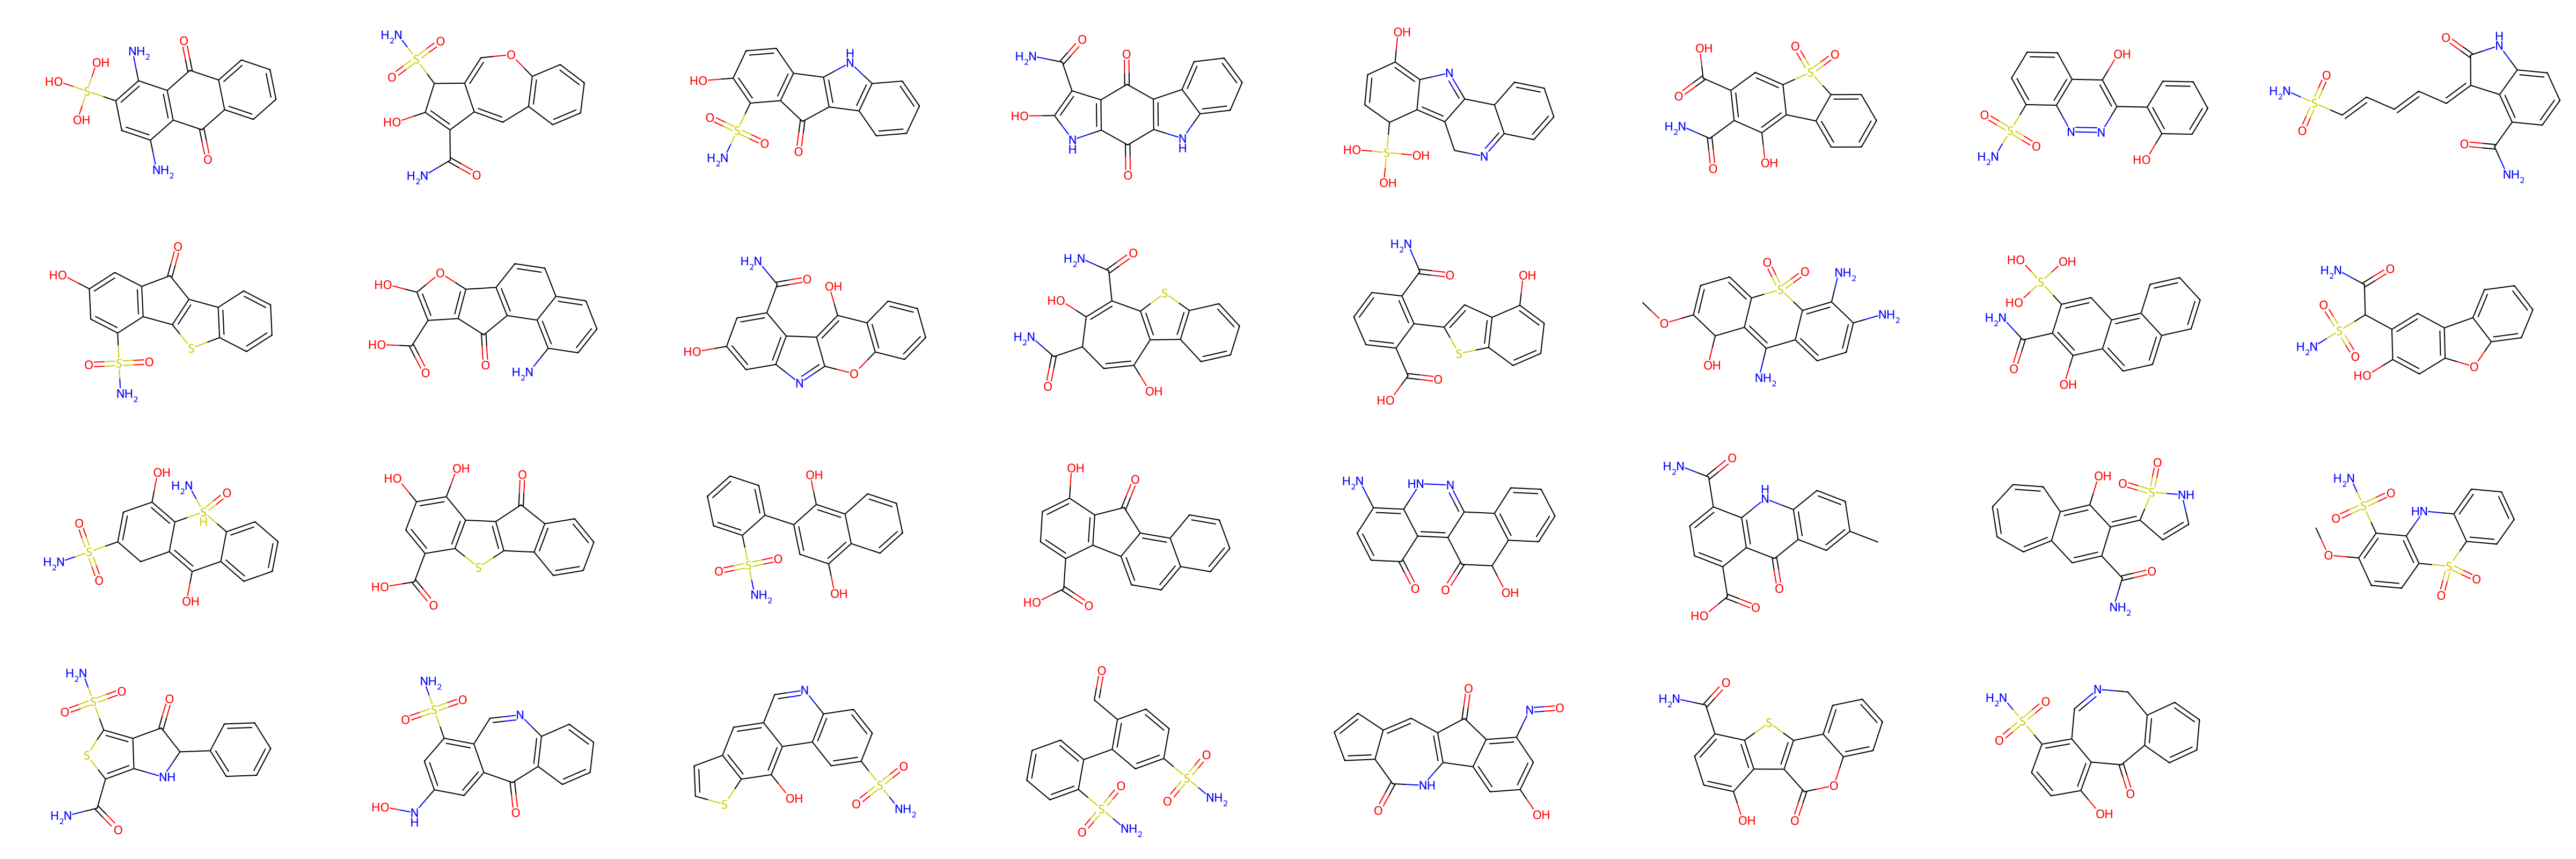

In [30]:
img=rdkit.Chem.Draw.MolsToGridImage(all_mols_flat ,
                                    molsPerRow=8,
                                    subImgSize=(600, 400),
                                    returnPNG=False
                                   )
img

### Lets check the sa_score

In [31]:
sas_conditional = np.array([calculate_sa(m).item() for m in all_mols_flat[1:]])

In [32]:
print(f"SA score of seed ligand: {calculate_sa(all_mols_flat[0]).item():.4f}")
print(f"Mean SA score in generated set: {np.mean(sas_conditional):.4f}")

SA score of seed ligand: 0.8203
Mean SA score in generated set: 0.7762


### Let's check the chemical similarity to the reference/seed
We choose ECFP4 with length 4096

In [33]:
ref_fp = get_fingerprints([reference_mol], radius=2, length=4096)[0]
gen_fps = get_fingerprints(all_mols_flat[1:], radius=2, length=4096)

In [34]:
ref_fp

In [35]:
tanimoto_sim = BulkTanimotoSimilarity(ref_fp, gen_fps)

In [36]:
print(f"tanimoto similarity stats: mean={np.mean(tanimoto_sim):.2f}, min={np.min(tanimoto_sim):.2f}, max={np.max(tanimoto_sim):.2f}")

tanimoto similarity stats: mean=0.20, min=0.07, max=0.30


### Let's reduce the influence from the latent embedding
We set $\lambda=0.5$

In [37]:
d = {


     'latent_gamma': 0.5,
     'encode_ligands': True,
    
     'num_gpus': 1, 
     'fix_n_nodes': True,
     'vary_n_nodes': False,
     'n_nodes_bias': 0,
     'prior_n_atoms': 'targetdiff',

     'sa_importance_sampling': False, 'sa_tau': 0.1, 'sa_every_importance_t': 5,
     'sa_importance_sampling_start': 0, 'sa_importance_sampling_end': 200,

    
     'test_dir': dataset_root + "/test/", 
     'pdbqt_dir': dataset_root + "/test/pdbqt/",
    
     'batch_size': batch_size,
}

d.update(defaults_d)
args = DotDict.from_dict(d)
embedding_dict = defaultdict(create_list_defaultdict)
hparams = model.hparams

In [38]:
all_mols_2d = []
all_mols_3d = []

its = 1

for i in range(its):
    molecules = prepare_data_and_generate_ligands(
                            model,
                            residues,
                            sdf_file,
                            dataset_info,
                            hparams=hparams,
                            args=args,
                            device=device,
                            embedding_dict=embedding_dict,
                            residues_10A=residues_10A,
                            inner_verbose=True,
                        )
    
    molecules = [m.rdkit_mol for m in molecules]
    all_mols_3d.append(molecules)
    
    molecules = [m for m in molecules if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
    
    if i == 0:
        # insert the first index as seed/reference ligand
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(reference_mol))] + [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
    else:
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
        
    all_mols_2d.append(mols2d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:03<00:00,  7.82it/s]


In [39]:
all_mols_flat = np.concatenate(all_mols_2d)
unique_smiles = []
for m in all_mols_flat:
    unique_smiles.append(Chem.MolToSmiles(m))
unique_smiles = list(set(unique_smiles))
valid_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in all_mols_flat]
validity = sum((a is not None for a in valid_mols)) / batch_size
print(f"Validity among {batch_size} generated samples = {validity:.4f}")
print(f"Uniqueness among valid samples={len(unique_smiles) / len(all_mols_flat):.4f}")

Validity among 32 generated samples = 0.8438
Uniqueness among valid samples=1.0000


In [40]:
natoms = np.array([m.GetNumAtoms() for m in all_mols_flat])
assert (natoms == reference_mol.GetNumAtoms()).all()

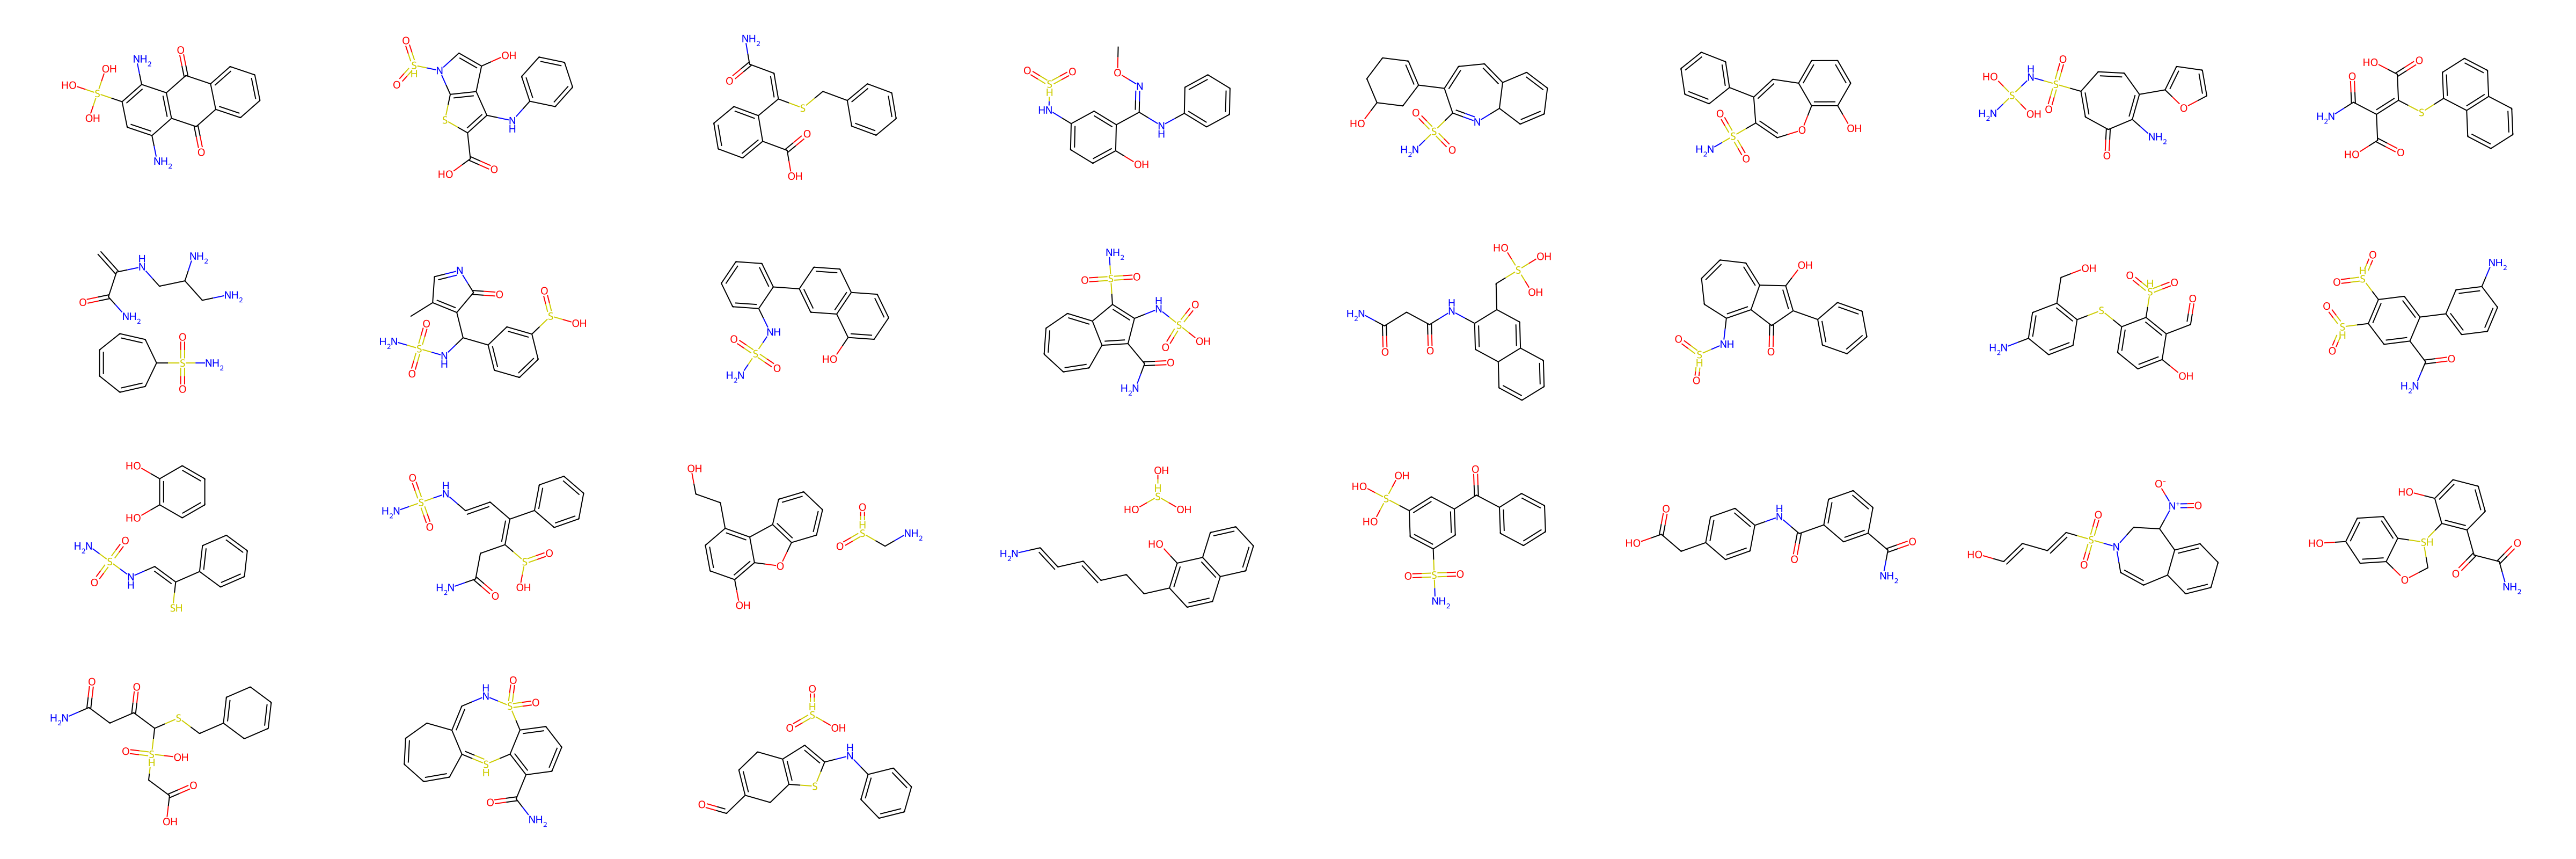

In [41]:
img=rdkit.Chem.Draw.MolsToGridImage(all_mols_flat ,
                                    molsPerRow=8,
                                    subImgSize=(600, 400),
                                    returnPNG=False
                                   )
img

In [42]:
sas_conditional = np.array([calculate_sa(m).item() for m in all_mols_flat[1:]])
print(f"SA score of seed ligand: {calculate_sa(all_mols_flat[0]).item():.4f}")
print(f"Mean SA score in generated set: {np.mean(sas_conditional):.4f}")

SA score of seed ligand: 0.8203
Mean SA score in generated set: 0.7300


In [43]:
ref_fp = get_fingerprints([reference_mol], radius=2, length=4096)[0]
gen_fps = get_fingerprints(all_mols_flat[1:], radius=2, length=4096)
tanimoto_sim_reduced_lambda = BulkTanimotoSimilarity(ref_fp, gen_fps)

In [44]:
print("Using lambda=1.0")
print(f"tanimoto similarity stats: mean={np.mean(tanimoto_sim):.2f}, min={np.min(tanimoto_sim):.2f}, max={np.max(tanimoto_sim):.2f}")

print("Using lambda=0.5")
print(f"tanimoto similarity stats: mean={np.mean(tanimoto_sim_reduced_lambda):.2f}, min={np.min(tanimoto_sim_reduced_lambda):.2f}, max={np.max(tanimoto_sim_reduced_lambda):.2f}")


Using lambda=1.0
tanimoto similarity stats: mean=0.20, min=0.07, max=0.30
Using lambda=0.5
tanimoto similarity stats: mean=0.15, min=0.08, max=0.27


We see that all tanimoto statistics reduced if the influence of the latent is also reduces

### Let's check if we increase the size of the ligand, while keeping lambda=1.0

We set `vary_n_nodes=True` and add uniformly atoms from $U(-3,3)$

In [45]:
d = {

     'latent_gamma': 1.,
     'encode_ligands': True,
    
     'num_gpus': 1, 
     'fix_n_nodes': True,
     'vary_n_nodes': True,
     'n_nodes_bias': 6,
     'prior_n_atoms': 'targetdiff',


     'sa_importance_sampling': False, 'sa_tau': 0.1, 'sa_every_importance_t': 5,
     'sa_importance_sampling_start': 0, 'sa_importance_sampling_end': 200,

   
     'test_dir': dataset_root + "/test/", 
     'pdbqt_dir': dataset_root + "/test/pdbqt/",
    
     'batch_size': batch_size,
}

d.update(defaults_d)
args = DotDict.from_dict(d)
embedding_dict = defaultdict(create_list_defaultdict)
hparams = model.hparams

In [46]:
all_mols_2d = []
all_mols_3d = []

its = 1

for i in range(its):
    molecules = prepare_data_and_generate_ligands(
                            model,
                            residues,
                            sdf_file,
                            dataset_info,
                            hparams=hparams,
                            args=args,
                            device=device,
                            embedding_dict=embedding_dict,
                            residues_10A=residues_10A,
                            inner_verbose=True,
                        )
    
    molecules = [m.rdkit_mol for m in molecules]
    all_mols_3d.append(molecules)
    
    molecules = [m for m in molecules if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
    
    if i == 0:
        # insert the first index as seed/reference ligand
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(reference_mol))] + [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
    else:
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
        
    all_mols_2d.append(mols2d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:04<00:00,  7.76it/s]


In [47]:
all_mols_flat = np.concatenate(all_mols_2d)
unique_smiles = []
for m in all_mols_flat:
    unique_smiles.append(Chem.MolToSmiles(m))
unique_smiles = list(set(unique_smiles))
valid_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in all_mols_flat]
validity = sum((a is not None for a in valid_mols)) / batch_size
print(f"Validity among {batch_size} generated samples = {validity:.4f}")
print(f"Uniqueness among valid samples={len(unique_smiles) / len(all_mols_flat):.4f}")

Validity among 32 generated samples = 0.9375
Uniqueness among valid samples=1.0000


In [48]:
natoms = np.array([m.GetNumAtoms() for m in all_mols_flat])
print(f"The seed ligand has {reference_mol.GetNumAtoms()} atoms, and now the generated ligands have the following # of atoms")
natoms

The seed ligand has 22 atoms, and now the generated ligands have the following # of atoms


array([22, 22, 24, 19, 19, 23, 22, 22, 22, 20, 23, 20, 24, 22, 20, 20, 20,
       23, 23, 24, 24, 23, 24, 24, 20, 23, 19, 24, 20, 20])

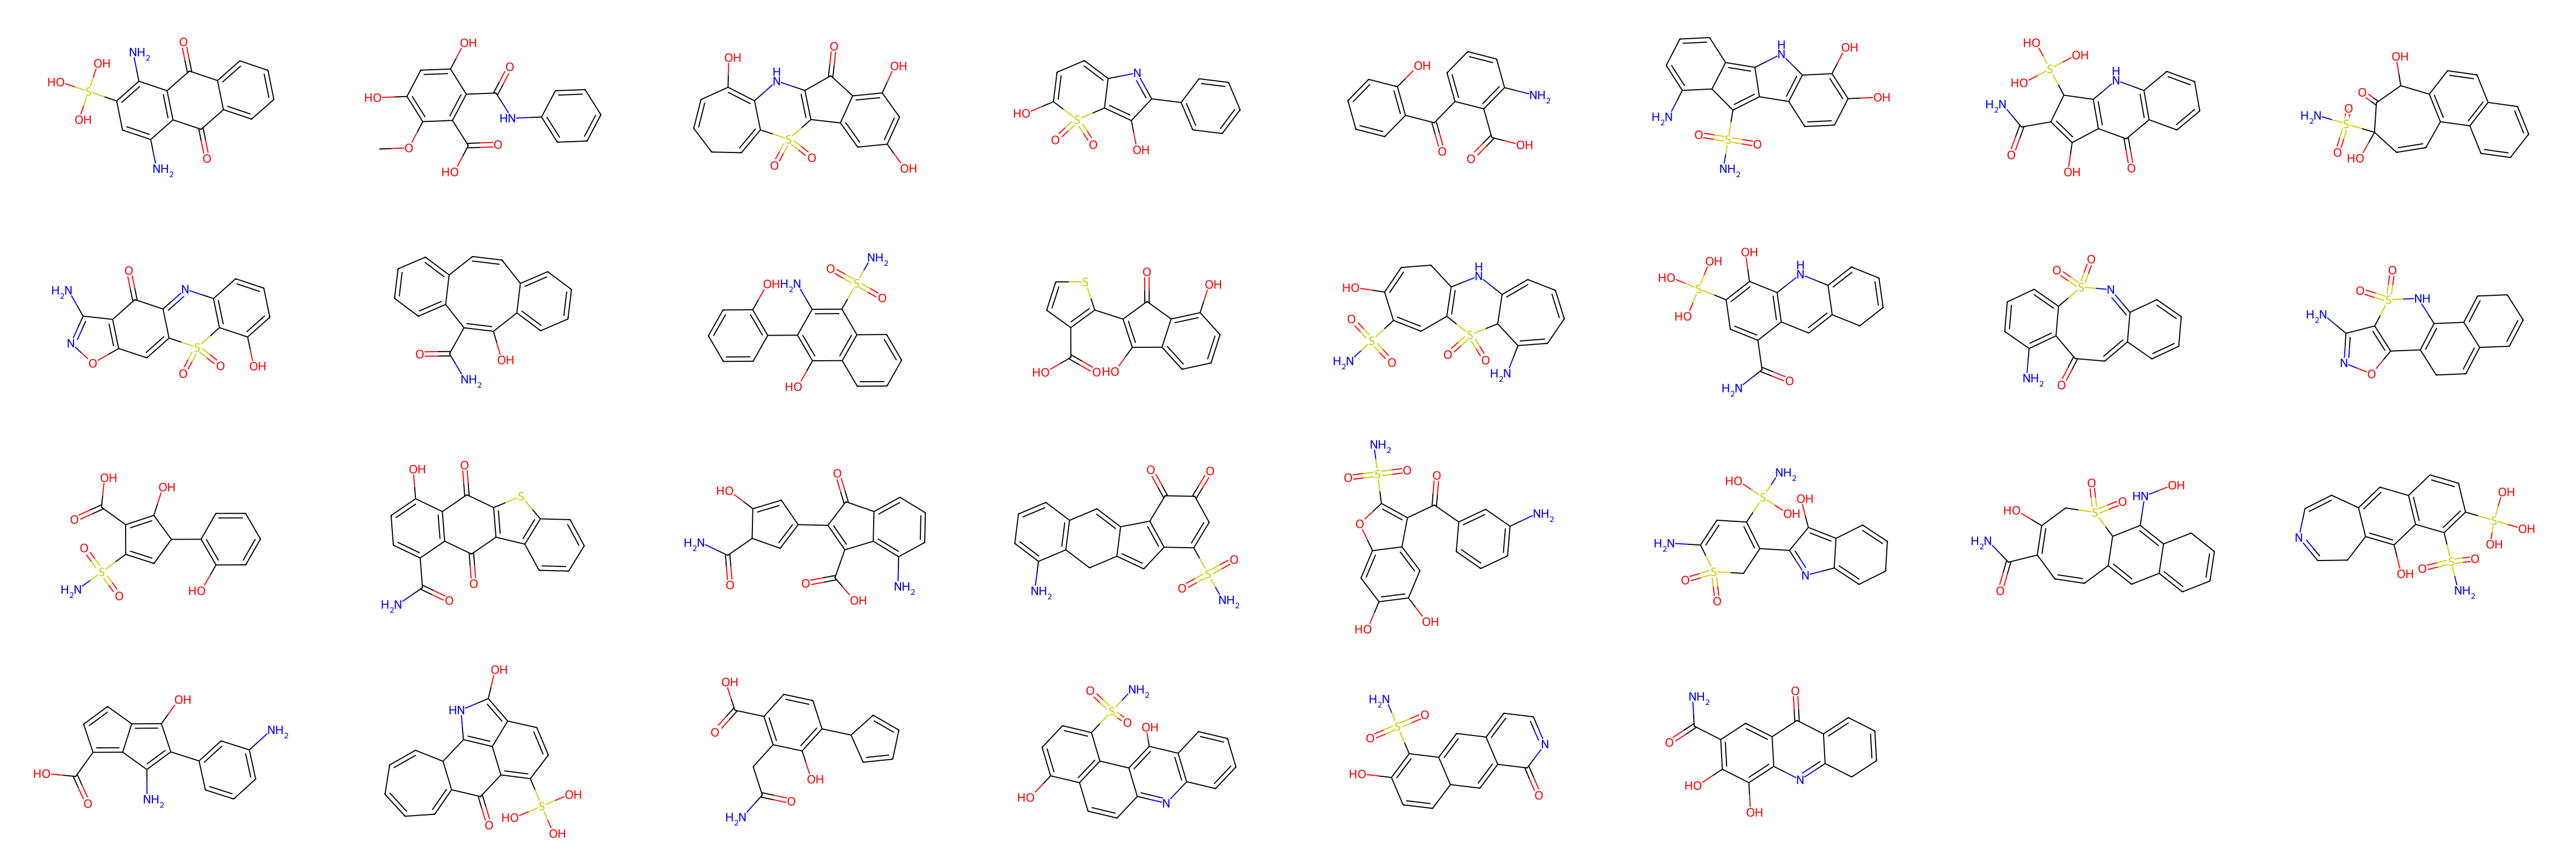

In [49]:
img=rdkit.Chem.Draw.MolsToGridImage(all_mols_flat ,
                                    molsPerRow=8,
                                    subImgSize=(600, 400),
                                    returnPNG=False
                                   )
img

### Let's add more atoms. 
Note we do not visualize the pocket here, but adding too much atoms might not fit well into the pocket

In [50]:
d = {

     'latent_gamma': 1.,
     'encode_ligands': True,
    
     'num_gpus': 1, 
     'fix_n_nodes': True,
     'vary_n_nodes': False,
     'n_nodes_bias': 6,
     'prior_n_atoms': 'targetdiff',

     'sa_importance_sampling': False, 'sa_tau': 0.1, 'sa_every_importance_t': 5,
     'sa_importance_sampling_start': 0, 'sa_importance_sampling_end': 200,

   
     'test_dir': dataset_root + "/test/", 
     'pdbqt_dir': dataset_root + "/test/pdbqt/",
    
     'batch_size': batch_size,
}

d.update(defaults_d)
args = DotDict.from_dict(d)
embedding_dict = defaultdict(create_list_defaultdict)
hparams = model.hparams

In [51]:
all_mols_2d = []
all_mols_3d = []

its = 1

for i in range(its):
    molecules = prepare_data_and_generate_ligands(
                            model,
                            residues,
                            sdf_file,
                            dataset_info,
                            hparams=hparams,
                            args=args,
                            device=device,
                            embedding_dict=embedding_dict,
                            residues_10A=residues_10A,
                            inner_verbose=True,
                        )
    
    molecules = [m.rdkit_mol for m in molecules]
    all_mols_3d.append(molecules)
    
    molecules = [m for m in molecules if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
    
    if i == 0:
        # insert the first index as seed/reference ligand
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(reference_mol))] + [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
    else:
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
        
    all_mols_2d.append(mols2d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:18<00:00,  6.34it/s]


In [52]:
all_mols_flat = np.concatenate(all_mols_2d)
unique_smiles = []
for m in all_mols_flat:
    unique_smiles.append(Chem.MolToSmiles(m))
unique_smiles = list(set(unique_smiles))
valid_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in all_mols_flat]
validity = sum((a is not None for a in valid_mols)) / batch_size
print(f"Validity among {batch_size} generated samples = {validity:.4f}")
print(f"Uniqueness among valid samples={len(unique_smiles) / len(all_mols_flat):.4f}")

Validity among 32 generated samples = 0.3750
Uniqueness among valid samples=1.0000


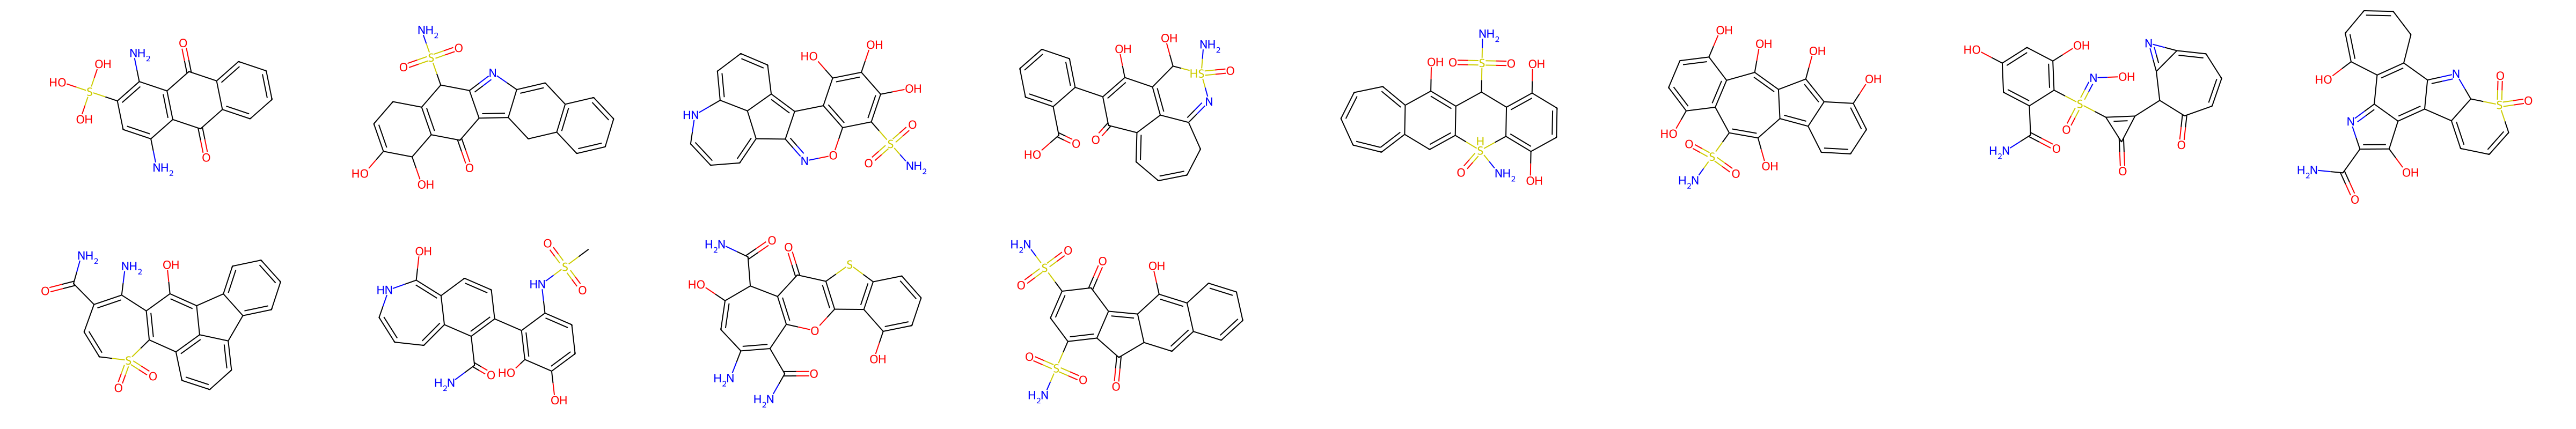

In [53]:
img=rdkit.Chem.Draw.MolsToGridImage(all_mols_flat ,
                                    molsPerRow=8,
                                    subImgSize=(600, 400),
                                    returnPNG=False
                                   )
img

#### As wee see, adding more atoms leads to more invalid molecules, such that the diffusion model cannot use the encoded seed $z$ to steer the generation towards the reference

We can reduce the influence of the latent $z$ and see how the generation goes

In [54]:
d = {

     'latent_gamma': 0.8,
     'encode_ligands': True,
    
     'num_gpus': 1, 
     'fix_n_nodes': True,
     'vary_n_nodes': False,
     'n_nodes_bias': 6,
     'prior_n_atoms': 'targetdiff',

     'sa_importance_sampling': False, 'sa_tau': 0.1, 'sa_every_importance_t': 5,
     'sa_importance_sampling_start': 0, 'sa_importance_sampling_end': 200,

   
     'test_dir': dataset_root + "/test/", 
     'pdbqt_dir': dataset_root + "/test/pdbqt/",
    
     'batch_size': batch_size,
}

d.update(defaults_d)
args = DotDict.from_dict(d)
embedding_dict = defaultdict(create_list_defaultdict)
hparams = model.hparams

In [55]:
all_mols_2d = []
all_mols_3d = []

its = 1

for i in range(its):
    molecules = prepare_data_and_generate_ligands(
                            model,
                            residues,
                            sdf_file,
                            dataset_info,
                            hparams=hparams,
                            args=args,
                            device=device,
                            embedding_dict=embedding_dict,
                            residues_10A=residues_10A,
                            inner_verbose=True,
                        )
    
    molecules = [m.rdkit_mol for m in molecules]
    all_mols_3d.append(molecules)
    
    molecules = [m for m in molecules if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
    
    if i == 0:
        # insert the first index as seed/reference ligand
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(reference_mol))] + [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
    else:
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
        
    all_mols_2d.append(mols2d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:17<00:00,  6.44it/s]


In [56]:
all_mols_flat = np.concatenate(all_mols_2d)
unique_smiles = []
for m in all_mols_flat:
    unique_smiles.append(Chem.MolToSmiles(m))
unique_smiles = list(set(unique_smiles))
valid_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in all_mols_flat]
validity = sum((a is not None for a in valid_mols)) / batch_size
print(f"Validity among {batch_size} generated samples = {validity:.4f}")
print(f"Uniqueness among valid samples={len(unique_smiles) / len(all_mols_flat):.4f}")

Validity among 32 generated samples = 0.5000
Uniqueness among valid samples=1.0000


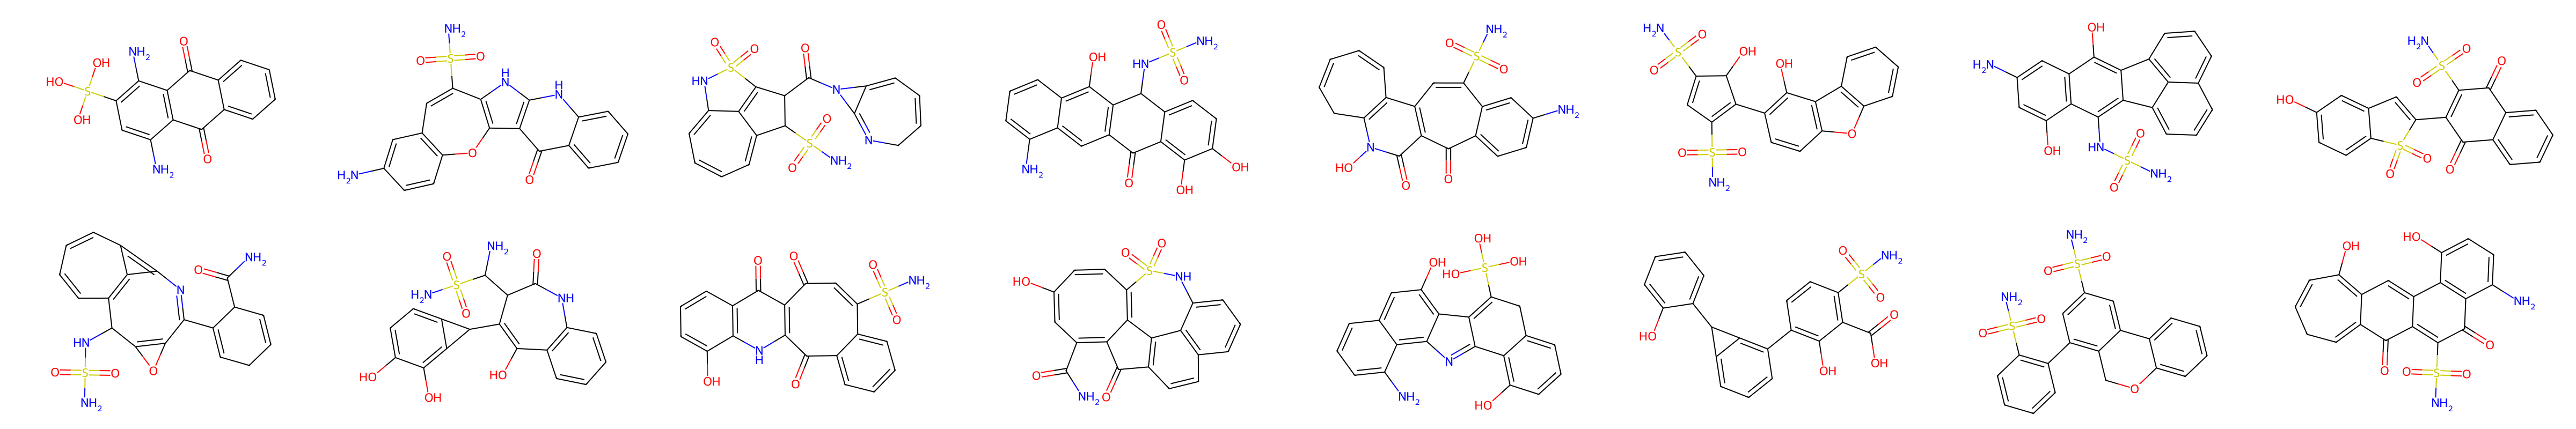

In [57]:
img=rdkit.Chem.Draw.MolsToGridImage(all_mols_flat ,
                                    molsPerRow=8,
                                    subImgSize=(600, 400),
                                    returnPNG=False
                                   )
img

### Perform conditional SA sampling while keeping the latent $z$

Combining recent works in [1]


>[1] Cremer J, Le T, Noé F, Clevert DA, Schütt KT. PILOT: equivariant diffusion for pocket-conditioned de novo ligand generation with multi-objective guidance via importance sampling. Chem Sci. 2024;15:14954-14967. doi:10.1039/D4SC03523B


We can include a surrogate model that can be used to compute importance weights to re-weight the diffusion trajectories.
In fact, the used model was jointly trained to also regress on the `SA` score during diffusion training. Hence, we can use the same model architecture to perform the guidance.

Let's check a test ligand that has a lower SA

In [58]:
test_ligands = []
test_sa_scores = []
for sdf_file in test_files:
    ref_mol = Chem.SDMolSupplier(str(sdf_file))[0]
    test_ligands.append(ref_mol)
    sa = calculate_sa(ref_mol)
    test_sa_scores.append(sa.item())
test_sa_scores = np.array(test_sa_scores) 

Text(0.5, 0, 'SA_score')

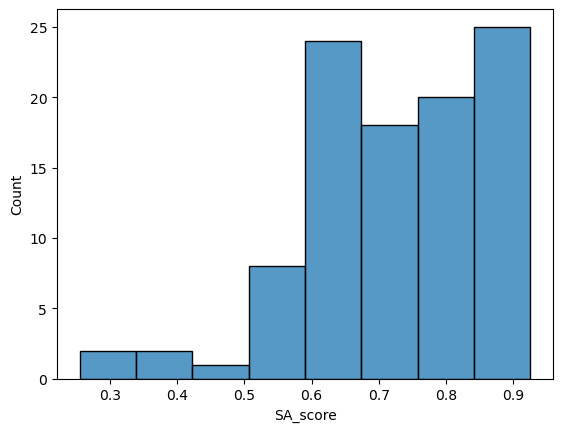

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(test_sa_scores)
plt.xlabel("SA_score")

In [77]:
print(np.round(np.mean(test_sa_scores), 2), np.round(np.std(test_sa_scores), 2))

0.73 0.14


0.13915936119580577

In [60]:
idx = (0.6 < test_sa_scores) * (test_sa_scores  < 0.8)

In [61]:
select = np.where(idx)[0]
select

array([ 2,  4,  6,  7,  8,  9, 11, 13, 15, 17, 18, 19, 21, 22, 26, 27, 28,
       36, 37, 40, 42, 43, 45, 47, 48, 50, 51, 54, 55, 58, 59, 60, 62, 63,
       64, 66, 67, 69, 73, 74, 79, 80, 81, 84, 89, 98, 99])

### Let's choose a test-ligand with lower SA score

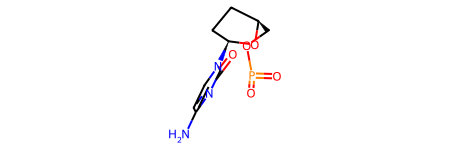

In [62]:
sdf_file = test_files[select[-5]]
suppl = Chem.SDMolSupplier(str(sdf_file))
mol = []
for m in suppl:
    mol.append(m)
assert len(mol) == 1
reference_mol = mol[0]
reference_mol

In [63]:
calculate_sa(reference_mol)

tensor([0.6663])

We perform importance sampling during the diffusion trajectory between the steps 
(0, 400) and apply it every 5 steps.

In [64]:
d = {

     'latent_gamma': 0.8,
     'encode_ligands': True,
    
     'num_gpus': 1, 
     'fix_n_nodes': True,
     'vary_n_nodes': False,
     'n_nodes_bias': 0,
     'prior_n_atoms': 'targetdiff',

     'sa_importance_sampling': True, 'sa_tau': 0.1, 'sa_every_importance_t': 5,
     'sa_importance_sampling_start': 0, 'sa_importance_sampling_end': 250,

     'test_dir': dataset_root + "/test/", 
     'pdbqt_dir': dataset_root + "/test/pdbqt/",
    
     'batch_size': batch_size,
}


d.update(defaults_d)
args = DotDict.from_dict(d)
embedding_dict = defaultdict(create_list_defaultdict)
hparams = model.hparams

In [65]:
args.sa_importance_sampling

True

In [66]:
all_mols_2d = []
all_mols_3d = []

its = 1

for i in range(its):
    molecules = prepare_data_and_generate_ligands(
                            model,
                            residues,
                            sdf_file,
                            dataset_info,
                            hparams=hparams,
                            args=args,
                            device=device,
                            embedding_dict=embedding_dict,
                            residues_10A=residues_10A,
                            inner_verbose=True,
                        )
    
    molecules = [m.rdkit_mol for m in molecules]
    all_mols_3d.append(molecules)
    
    molecules = [m for m in molecules if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
    
    if i == 0:
        # insert the first index as seed/reference ligand
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(reference_mol))] + [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
    else:
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
        
    all_mols_2d.append(mols2d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:10<00:00,  7.13it/s]


In [67]:
all_mols_flat = np.concatenate(all_mols_2d)
unique_smiles = []
for m in all_mols_flat:
    unique_smiles.append(Chem.MolToSmiles(m))
unique_smiles = list(set(unique_smiles))
valid_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in all_mols_flat]
validity = sum((a is not None for a in valid_mols)) / batch_size
print(f"Validity among {batch_size} generated samples = {validity:.4f}")
print(f"Uniqueness among valid samples={len(unique_smiles) / len(all_mols_flat):.4f}")

Validity among 32 generated samples = 1.0000
Uniqueness among valid samples=0.8125


In [68]:
sas_conditional = np.array([calculate_sa(m).item() for m in all_mols_flat[1:]])
print(f"SA score of seed ligand: {calculate_sa(all_mols_flat[0]).item():.4f}")
print(f"Mean SA score in generated set: {np.mean(sas_conditional):.4f}")

SA score of seed ligand: 0.6663
Mean SA score in generated set: 0.8511


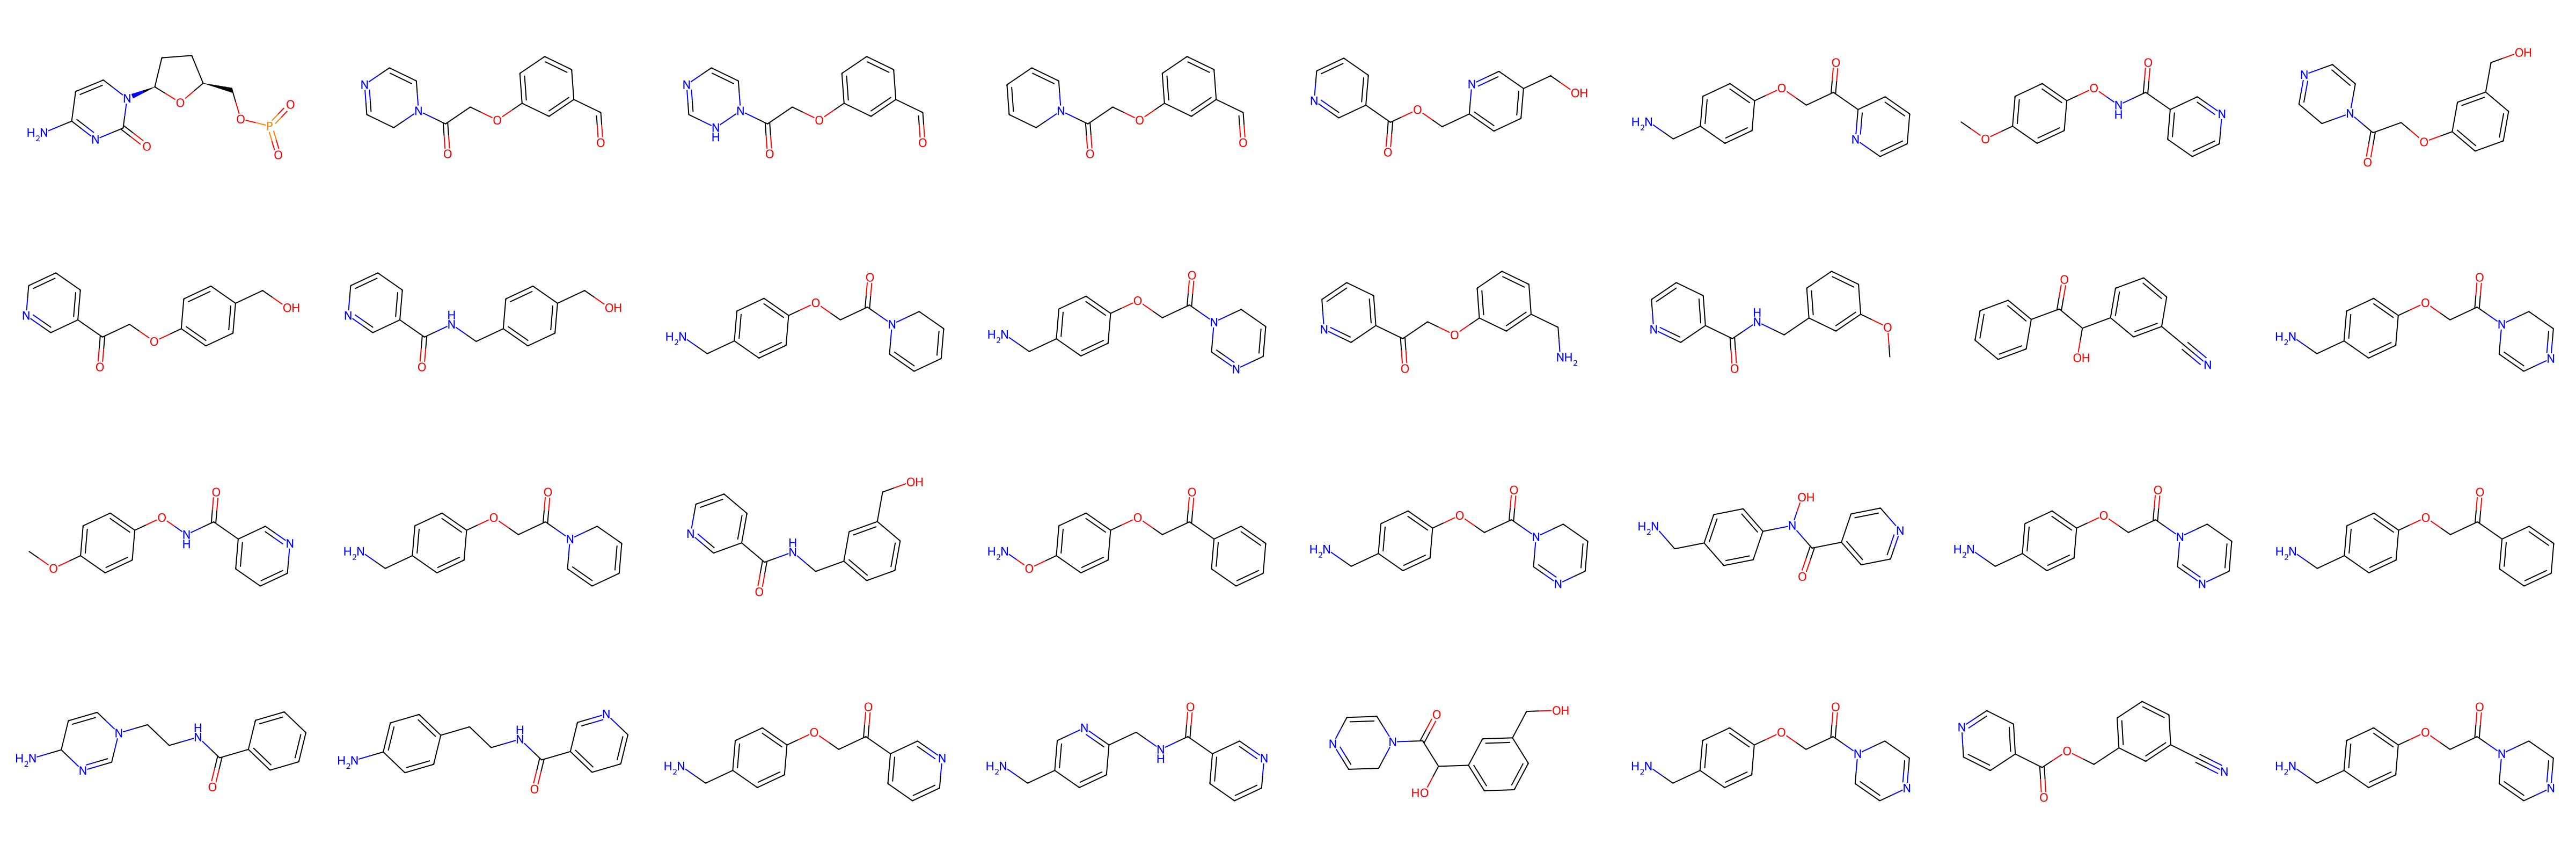

In [69]:
img=rdkit.Chem.Draw.MolsToGridImage(all_mols_flat ,
                                    molsPerRow=8,
                                    subImgSize=(600, 400),
                                    returnPNG=False
                                   )
img

#### For this ligand, the SA can be drastically improved. Let's check if we do not perform SA guidance

In [70]:
d = {

     'latent_gamma': 0.8,
     'encode_ligands': True,
    
     'num_gpus': 1, 
     'fix_n_nodes': True,
     'vary_n_nodes': False,
     'n_nodes_bias': 0,
     'prior_n_atoms': 'targetdiff',

     'sa_importance_sampling': False, 'sa_tau': 0.1, 'sa_every_importance_t': 5,
     'sa_importance_sampling_start': 0, 'sa_importance_sampling_end': 250,

     'test_dir': dataset_root + "/test/", 
     'pdbqt_dir': dataset_root + "/test/pdbqt/",
    
     'batch_size': batch_size,
}


d.update(defaults_d)
args = DotDict.from_dict(d)
embedding_dict = defaultdict(create_list_defaultdict)
hparams = model.hparams
args.sa_importance_sampling

False

In [71]:
all_mols_2d = []
all_mols_3d = []

its = 1

for i in range(its):
    molecules = prepare_data_and_generate_ligands(
                            model,
                            residues,
                            sdf_file,
                            dataset_info,
                            hparams=hparams,
                            args=args,
                            device=device,
                            embedding_dict=embedding_dict,
                            residues_10A=residues_10A,
                            inner_verbose=True,
                        )
    
    molecules = [m.rdkit_mol for m in molecules]
    all_mols_3d.append(molecules)
    
    molecules = [m for m in molecules if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
    
    if i == 0:
        # insert the first index as seed/reference ligand
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(reference_mol))] + [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
    else:
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
        
    all_mols_2d.append(mols2d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:56<00:00,  8.83it/s]


In [72]:
all_mols_flat = np.concatenate(all_mols_2d)
unique_smiles = []
for m in all_mols_flat:
    unique_smiles.append(Chem.MolToSmiles(m))
unique_smiles = list(set(unique_smiles))
valid_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in all_mols_flat]
validity = sum((a is not None for a in valid_mols)) / batch_size
print(f"Validity among {batch_size} generated samples = {validity:.4f}")
print(f"Uniqueness among valid samples={len(unique_smiles) / len(all_mols_flat):.4f}")

Validity among 32 generated samples = 0.9688
Uniqueness among valid samples=0.9677


In [74]:
sas_unconditional = np.array([calculate_sa(m).item() for m in all_mols_flat[1:]])
print(f"SA score of seed ligand: {calculate_sa(all_mols_flat[0]).item():.4f}")
print(f"Mean SA score in SA-guided and latent generated set: {np.mean(sas_conditional):.4f}")
print(f"Mean SA score in latent generated set: {np.mean(sas_unconditional):.4f}")

SA score of seed ligand: 0.6663
Mean SA score in SA-guided and latent generated set: 0.8511
Mean SA score in latent generated set: 0.6253


We observe that the latent conditioning alone does not lead to improved SA, but stays around the seed ligand.
The importance sampling guidance can therefore be used simultaneously with the latent conditioning.